## Install prerequisite libraries

In [ ]:
# !pip install pymatgen
# !pip install ase
# !pip install mp_api

# Run example script for calculating classical descriptor values
* Use the example_data.pkl for the dataset (10 datapoints from GASdb)
* Function: get_act_site_index(struct, ads_idx) is a function to determine the active site index given the adsorbate index and the slab structure object
* Use a cutoff length of 4.5 $\AA$ for near-neighbor finder
* Use the first cell to run the function and the following cell to run the code that calculates required descriptors

In [10]:
from pymatgen.analysis.local_env import MinimumDistanceNN
def get_act_site_index(struct, ads_idx):
    '''
    Inputs: pymatgen structure, adsorbate index
    Output: active site index
    '''
    cutoff_dist = 4.5
    mnn = MinimumDistanceNN(cutoff=cutoff_dist, get_all_sites=True)
    nn_list = mnn.get_nn_info(struct,ads_idx)
    act_site_idx = 0
    act_site_dist = 10
    for nn in nn_list:
        if nn['site'].specie != Element('H'):
            if nn['weight'] < act_site_dist:
                act_site_dist = nn['weight']
                act_site_idx = nn['site_index']
    return act_site_idx

In [11]:
from pymatgen.core.structure import Structure
import pickle
import numpy as np
import pandas
import copy
from classical_descriptors import *
from moments_descriptors import *
from mp_api.client import MPRester
define_global_variables_moments()
define_global_variables_classical(4.5)

# Load the data file
with open('./example_data.pkl','rb') as pf:
    ds_full = pickle.load(pf)   # Dataset is loaded here

# Initialize list for storing the calculated descriptors
new_list = list()
for d in ds_full:
    mat_id = d['mpid']
    # Obtain the CIF for the bulk structure from Materials Project
    # Comment out this code if you have CIF structure already in the dataset:
    # Your Materials Project API key goes here
    mp_api_key = '7CIuGl1xbKasdaqBiimUYc8EaqvEbmJe' # Your API key here
    
    with MPRester(mp_api_key) as mpr:
        docs = mpr.materials.search(
            material_ids=[mat_id], fields=['initial_structures'])
    d['cif_struct'] = docs[0].initial_structures[0]
    
    # Make pymatgen Structure object for further calculations
    atom_list_init = d['init_struct']['atoms']['atoms']
    atom_list_fin = d['final_struct']['atoms']
    # Lists of species and coordinates are initialized here
    specie_list = list()
    coords_list_init = list()
    coords_list_fin = list()
    # Slab lattice is stored here
    lattice = d['init_struct']['atoms']['cell']
    for at_init, at_fin in zip(atom_list_init, atom_list_fin):
        specie_list.append(Element(at_init['symbol']))
        coords_list_init.append(at_init['position'])
        coords_list_fin.append(at_fin['position'])
    # Obtain the pymatgen structure
    py_struct_init = Structure(lattice, specie_list, coords_list_init, coords_are_cartesian=True)
    py_struct_fin = Structure(lattice, specie_list, coords_list_fin, coords_are_cartesian=True)

    # active_site_index = get_site_index_from_coords(py_struct_init, get_act_site_coords(py_struct_init, d['adsorbate']))
    # For GAS dataset, 0 is the adsorbate index; for OCP dataset, the adsorbate is mentioned as a key in the dictionary
    active_site_index = get_act_site_index(py_struct_init,0)
    active_site_coords = atom_list_init[active_site_index]['position']
    active_site_coords_fin = atom_list_fin[active_site_index]['position']
    # Open a new dictionary to modify key-value pairs
    new_dict = dict()
    new_dict = copy.deepcopy(d)
    # These are the descriptors to be chosen based on your need: 
    # psi, 
    # CN, 
    # CN_bar, 
    # CN_bar_sd
    
    # new_dict['psi'] = get_psi(py_struct_init, active_site_coords)
    # mu2_value = get_mu2_sum(py_struct_fin, active_site_coords_fin)
    # cif_struct = d['cif_struct']
    # bulk_V = get_bulk_V(d['cif_struct'])
    # new_dict['CN_bar_sd']  = mu2_value/(bulk_V)   
    new_dict['CN_max'] = get_CN_max(d['cif_struct'])
    new_dict['CN'] = get_CN(py_struct_init, active_site_coords)
    new_dict['CN_bar'] = get_CN_bar(py_struct_init, active_site_coords, new_dict['CN_max'])
    new_list.append(new_dict)
df = pandas.DataFrame(new_list)

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


## Plot energy values of data vs the descriptor values to check for linear correlations
* Obtain the list of energy values from the dataset
* Obtain the list of calculated descriptor values
* Scatter plot using matplotlib
* Use np.polyfit to obtain the linear equation
* Plot the best-fit linear equation and obtain the R^2 value for the same

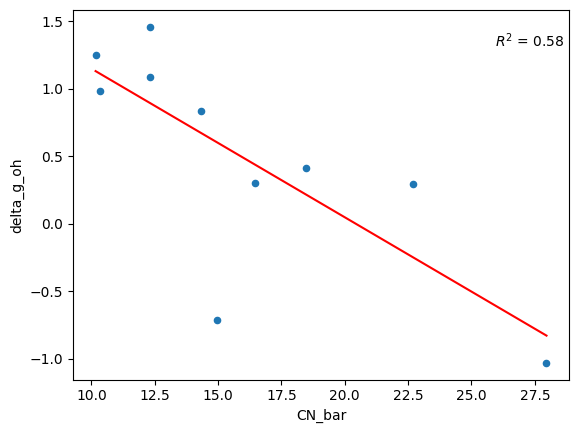

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

# Check the descriptor name and the energy value to be plotted
descriptor = 'CN_bar'      # Change based on descriptor name
energy_column = 'delta_g_oh'    # Change based on energy to be calculated
# Use a scatter plot for the descriptor vs energy
ax = df.plot.scatter(x=descriptor,y=energy_column)

# Get the best-fit linear equation correlation
coeffs = np.polyfit(df[descriptor],df[energy_column],1)
p = np.poly1d(coeffs)
x_line = np.linspace(df[descriptor].min(), df[descriptor].max(), 100)
ax.plot(x_line, p(x_line), color='red')
# Get R^2 values
slope, intercept, r_value, p_value, std_err = stats.linregress(df[descriptor], df[energy_column])
r_squared = r_value**2
ax.annotate(f"$R^2$ = {r_squared:.2f}", xy=(0.85, 0.9), xycoords='axes fraction')

# Add labels to the plot
plt.xlabel(descriptor)
plt.ylabel(energy_column)
plt.show()

## Use best-fit linear correlation of descriptor to predict energy values and compare with calculated value

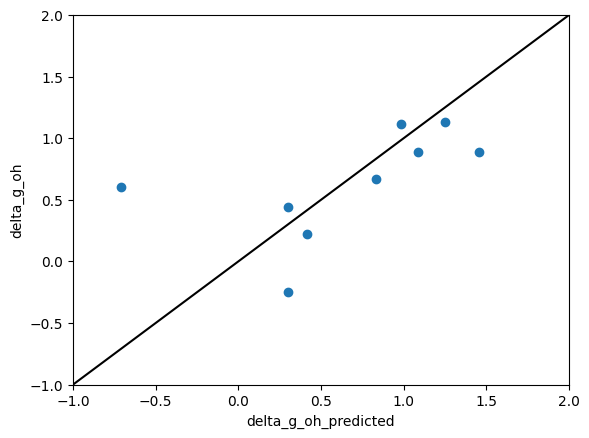

In [28]:
# Predict value of energy based on the linear-fit line
predicted_values = p(df[descriptor])
lims = [-1,2]
xy_line = np.linspace(lims[0],lims[1],50)
# Scatter the plot
fig, ax2 = plt.subplots()
ax2.scatter(df[energy_column],predicted_values)
ax2.plot(xy_line,xy_line,color='k')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_ylabel(energy_column)
ax2.set_xlabel(energy_column+'_predicted')
plt.show()